In [6]:
#付録14.A
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime, date
import pandas as pd
import csv
import numpy as np

def readcsv(file_name):
    trades=[]
    with open(file_name,'r') as f:
        series=csv.reader(f)
        n=0
        for line in series:
            trades.append([])
            for elements in line:
                trades[n].append(elements)
            n=n+1
    f.close()
    return trades

In [7]:
#付録14.B
def sessiondata(trades,n_max,i,yymmdd,hm):
    j=0
    if hm==1900:# 米国時間、日本時間朝9：00
        jmax=0
        p99=float(trades[i][2])
        for j in range(n_max-i-1):
            yymmdd9=int(trades[i+j+1][0])
            hm9=int(trades[i+j+1][1])
            p9=float(trades[i+j+1][2])
            if yymmdd9>yymmdd:#実際の引けは日本時間午後3:15。
                if hm9<=110:                        
                    jmax=j
                if hm9>115:#実際の引けは日本時間午後3:15。
                    break
        price=trades[i:i+jmax+1]
    if hm==230:#日本時間午後4：30
        jmax=0
        p99=float(trades[i][2])
        for j in range(n_max-i-1):
            p9=float(trades[i+j+1][2])
            hm9=int(trades[i+j+1][1])
            if hm9<=1255:#日本時間朝2時55分
                jmax=j
            if hm9>1300:#日本時間朝3時
                break
        price=trades[i:i+jmax+1]
    return price,j

20150731 3095303
0 3095301 0


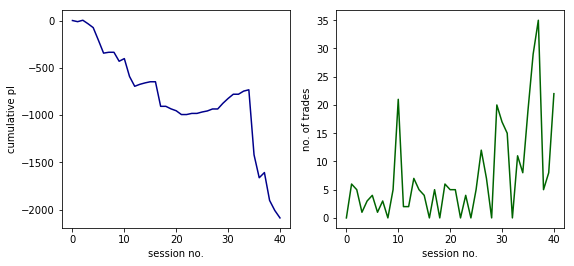

In [8]:
#15.A 保守的なマーケットメイキングのモデル
def analysis(trades):#sell first and buy back
    n_max=len(trades)
    forward=0
    yymmdd0=int(trades[0][0])
    results=[]
    I=[]
    zN=[]
    t=0
    iii=0
    pr=0 #プラスの価格差の数
    for i in range(n_max-2):
        yymmdd=int(trades[i][0])
        hm=int(trades[i][1])
        if i>=forward:
            price,j=sessiondata(trades,n_max,i,yymmdd,hm)
            if hm==1900 or hm==230:#データの分析-----------------------------     
                length=len(price)
                trade0=float(price[0][2])
                trade00=trade0+5          #売指値
                tradeS=0                  #ポジションの価格　0：ポジションの価格無し
                tradeStp=0                #利食いの買指値 0: 利食いの買指値無し。
                pl=0
                sss=0                     #取引の数
                for ii in range(1,length):
                    trade=float(price[ii][2])
                    bid=float(price[ii][3])
                    offer=float(price[ii][4])
                    if offer<bid:
                        offer=bid+5
                    if trade>=trade00+5 and tradeS==0:#建玉
                        tradeS=trade00
                        tradeStp=trade00-5
                        sss+=1
                    if tradeS!=0 and trade<=tradeStp-5:#利食い
                        pl+=5-2
                        tradeS=0
                        tradeStp=0
                        trade00=offer+5
                    trade0=trade
                if tradeS!=0: #逆選択ポジションの処理
                    pl+=tradeS-offer-2
                I.append([])
                I[t].append(pl)
                I[t].append(sss)
                t+=1
            forward=i+j+1
    print(pr,n_max-2,iii)
    I=pd.DataFrame(I,columns=['pl','sss'])
    plt.figure(figsize=(9,4))
    plt.subplot(1,2,1)
    plt.plot(I.pl[:-1].cumsum(),color='darkblue')
    plt.ylabel('cumulative pl')
    plt.xlabel('session no.')
    plt.subplot(1,2,2)
    plt.plot(I.sss[:-1],color='darkgreen')
    plt.ylabel('no. of trades')
    plt.xlabel('session no.')
    
buf_path0="C:\\users\\moriya\\documents\\Database\\n225\\tick\\"
t1=datetime.now()
if __name__ == "__main__":
    filenames=["n225m201508Sep.csv"]
    filename=filenames[0]
    file_name=buf_path0+filename
    trades=readcsv(file_name)
    yymmdd=trades[0][0]
    print(yymmdd,len(trades))
    analysis(trades)  


20150731 3095303
-8.66089965397924 -5006.0 578


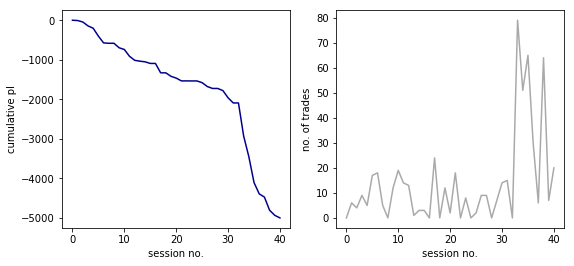

In [9]:
#15.B 保守的なマーケットメイキングのモデル+損切戦略
def analysis(trades):#sell first and buy back ----stop loss-----
    n_max=len(trades)
    forward=0
    yymmdd0=int(trades[0][0])
    results=[]
    I=[]
    zN=[]
    t=0
    for i in range(n_max-2):
        yymmdd=int(trades[i][0])
        hm=int(trades[i][1])
        if i>=forward:
            price,j=sessiondata(trades,n_max,i,yymmdd,hm)
            if hm==1900 or hm==230:#データの分析-----------------------------     
                length=len(price)
                trade0=float(price[0][2])
                trade00=trade0+5#売指値
                tradeS=0#売りポジションの価格
                tradeStp=0#利食いの買い指値
                pl=0.0
                sss=0#取引の数
                for ii in range(1,length):
                    trade=float(price[ii][2])
                    bid=float(price[ii][3])
                    offer=float(price[ii][4])
                    if offer<bid:
                        offer=bid+5
                    if trade>=trade00+5 and tradeS==0:
                        tradeS=trade00
                        tradeStp=trade00-5
                        tradeSsl=trade00+20#ストップロスの買指値
                        sss+=1
                    if tradeS!=0 and trade<=tradeStp-5:#利食い
                        pl+=5-2
                        tradeS=0
                        tradeStp=0
                        trade00=offer+5
                    if tradeS!=0 and trade>=tradeSsl:#ストップロス
                        pl+=tradeS-offer-2
                        tradeS=0
                        tradeStp=0
                        trade00=offer+5
                if tradeS!=0:
                    pl+=tradeS-offer-2
                I.append([])
                I[t].append(pl)
                I[t].append(sss)
                t+=1
            forward=i+j+1
    I=pd.DataFrame(I,columns=['pl','sss'])
    print(I.pl.sum()/I.sss.sum(),I.pl.sum(),I.sss.sum())
    plt.figure(figsize=(9,4))
    plt.subplot(1,2,1)
    plt.plot(I.pl[:-1].cumsum(),color='darkblue')
    plt.ylabel('cumulative pl')
    plt.xlabel('session no.')
    plt.subplot(1,2,2)
    plt.plot(I.sss[:-1],color='darkgray')
    plt.ylabel('no. of trades')
    plt.xlabel('session no.')
    
buf_path0="C:\\users\\moriya\\documents\\Database\\n225\\tick\\"
t1=datetime.now()
if __name__ == "__main__":
    filenames=["n225m201508Sep.csv"]
    filename=filenames[0]
    file_name=buf_path0+filename
    trades=readcsv(file_name)
    yymmdd=trades[0][0]
    print(yymmdd,len(trades))
    analysis(trades)  

20150731 3095303
-62.0 20150804 1900
-72.0 20150805 230
-7.0 20150806 1900
-132.0 20150809 1900
-37.0 20150810 230
-117.0 20150812 1900
-427.0 20150825 1900
-27.0 20150826 230
-192.0 20150827 230


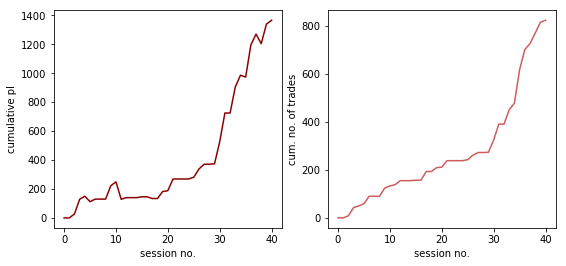

In [10]:
#15.C 保守的なマーケットメイキングのモデル:タイミングモデル
def analysis(trades):#sell first and buy back ----stop loss-----
    n_max=len(trades)
    forward=0
    yymmdd0=int(trades[0][0])
    results=[]
    I=[]
    zN=[]
    t=0
    for i in range(n_max-2):
        yymmdd=int(trades[i][0])
        hm=int(trades[i][1])
        if i>=forward:
            price,j=sessiondata(trades,n_max,i,yymmdd,hm)
            if hm==1900 or hm==230:#データの分析-----------------------------     
                length=len(price)
                ii=0
                trade0=float(price[ii][2])
                bid=float(price[ii][3])  #買気配
                offer=float(price[ii][4])#売気配
                v=float(price[ii][5])    #約定枚数
                ib=float(price[ii][6])   #買気配数
                io=float(price[ii][7])   #売気配数
                qo=io                    #順番待ち行列
                trade00=offer+50        #売指値の初期水準：キーファクター or 100
                tradeS=0
                tradeStp=0
                pl=0
                iii=0
                sss=0
                sss0=0
                for ii in range(1,length):
                    trade=float(price[ii][2])
                    bid=float(price[ii][3])
                    offer=float(price[ii][4])
                    if offer<bid:
                        offer=bid+5
                    v=float(price[ii][5])
                    ib=float(price[ii][6])
                    io=float(price[ii][7])
                    if trade00==offer and qo>15 and (io<200 or ib>400):#注文キャンセル
                        trade00=offer+5
                        qo=ib
                    if trade==trade00 and tradeS==0 and qo>0:#売り注文待ち行列の減少
                        qo-=v
                    if trade==trade00 and tradeS==0 and qo<=0:#注文約定
                        tradeS=trade00
                        tradeStp=trade00-5 #買い注文の発注
                        qb=ib
                        sss+=1
                    if trade>=trade00+5 and tradeS==0:#価格上昇による注文約定
                        tradeS=trade00
                        tradeStp=trade00-5
                        qb=ib
                        sss+=1
                        iii=0                   
                    if trade==tradeStp and tradeS!=0 and qb>0:
                        qb-=v
                    if trade==tradeStp and tradeS!=0 and qb<=0: #価格下落による利食い
                        pl+=5-2
                        tradeS=0
                        tradeStp=0
                        qo=io
                        trade00=offer+5
                        #sss0+=1
                    if tradeS!=0 and trade<=tradeStp-5:#価格下落による利食い
                        pl+=5-2
                        tradeS=0
                        tradeStp=0
                        trade00=offer+5
                        qo=io
                        #sss0+=1
                    iii+=1
                if tradeS!=0:
                    pl0=tradeS-offer-2
                    pl+=pl0
                    print(pl0,yymmdd,hm)
                else:
                    pl0=0
                I.append([])
                I[t].append(pl)
                I[t].append(sss)
                I[t].append(sss0)
                I[t].append(pl0)
                t+=1
            forward=i+j+1
    I=pd.DataFrame(I,columns=['pl','sss','sss0','sl'])
    plt.figure(figsize=(9,4))
    plt.subplot(1,2,1)
    plt.plot(I.pl[:-1].cumsum(),color='darkred')
    plt.ylabel('cumulative pl')
    plt.xlabel('session no.')
    plt.subplot(1,2,2)
    plt.plot(I.sss[:-1].cumsum(),color='indianred')
    plt.ylabel('cum. no. of trades')
    plt.xlabel('session no.')

buf_path0="C:\\users\\moriya\\documents\\Database\\n225\\tick\\"
t1=datetime.now()
if __name__ == "__main__":
    filenames=["n225m201508Sep.csv"]
    filename=filenames[0]
    file_name=buf_path0+filename
    trades=readcsv(file_name)
    yymmdd=trades[0][0]
    print(yymmdd,len(trades))
    analysis(trades)  